<a href="https://colab.research.google.com/github/MadanMaram/CIFAR-10-Pytorch/blob/master/cifar10_pytorch_GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Cifar-10 Classifier using GoogLeNet

## GoogLeNet
We chose GoogLeNet as our team-name in the ILSVRC14 competition. This name is an homage to
Yann LeCuns pioneering LeNet 5 network [10]. We also use GoogLeNet to refer to the particular
incarnation of the Inception architecture used in our submission for the competition. We have also
used a deeper and wider Inception network, the quality of which was slightly inferior, but adding it
to the ensemble seemed to improve the results marginally. 

In [2]:
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
   
if train_on_gpu:
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

CUDA is available! Training on GPU...


In [4]:
# Number of subprocesses to use for data loading
num_workers = 0

# How many samples per batch to load
batch_size = 20

# Percentage of training set to use as validation
n_valid = 0.2

# Convert data to a normalized torch.FloatTensor
# Data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
                                transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Select training_set and testing_set
train_data = datasets.CIFAR10("data", 
                              train= True,
                             download=True,
                             transform = transform)

test_data = datasets.CIFAR10("data", 
                              train= False,
                             download=True,
                             transform = transform)

# Get indices for training_set and validation_set
n_train = len(train_data)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                          sampler = train_sampler,
                                          num_workers = num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                          sampler = valid_sampler,
                                          num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size = batch_size,
                                          num_workers = num_workers)

# Specify the image classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

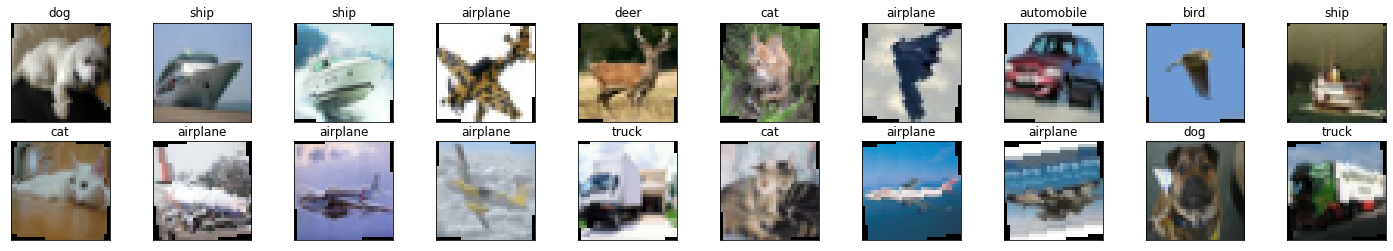

In [6]:
# Get one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

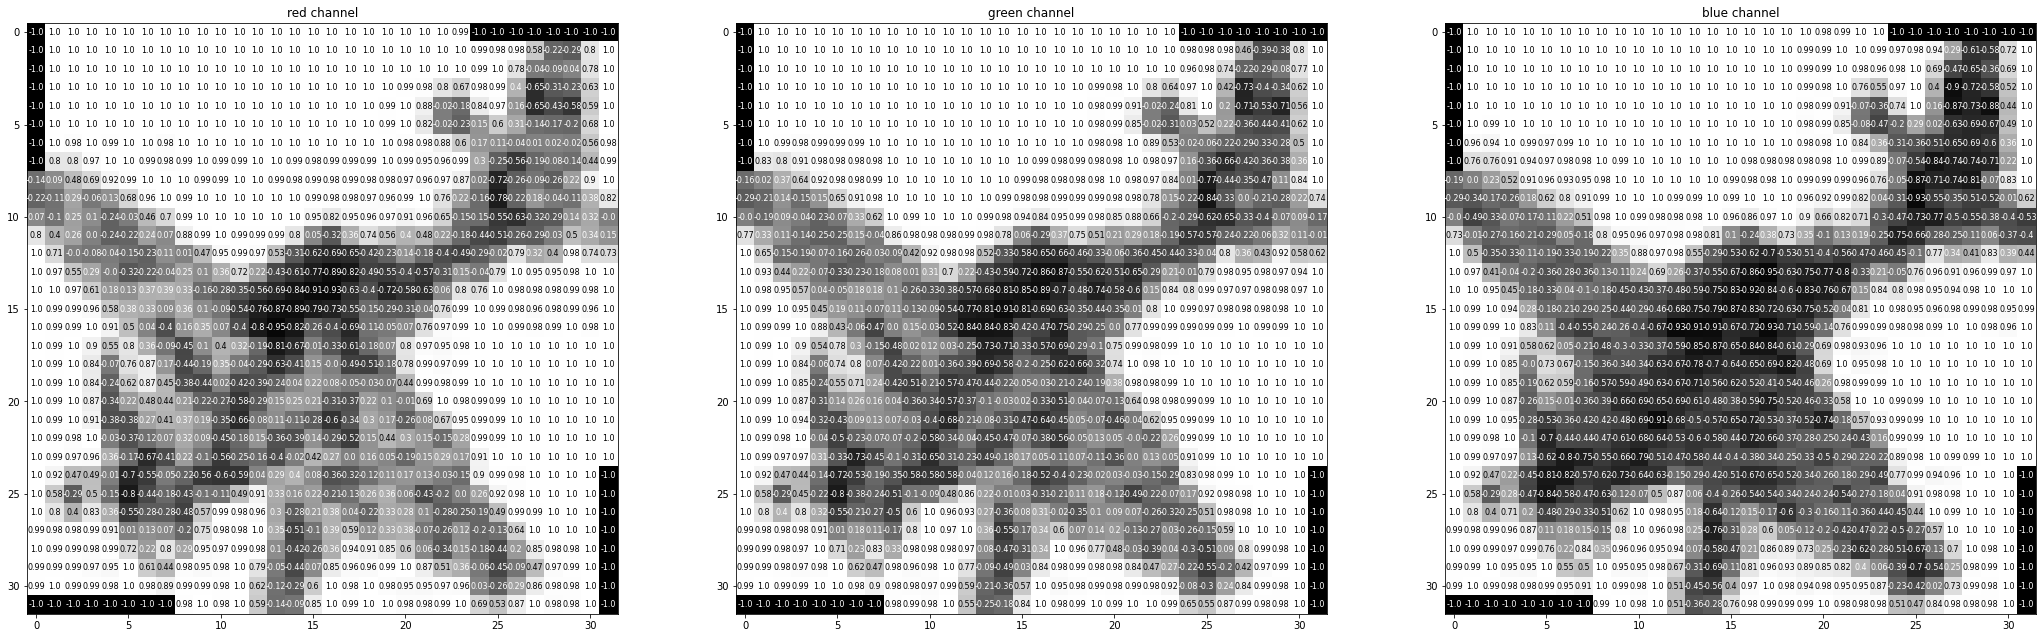

In [7]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Define GoogleNet(Inception)

In [9]:
'''GoogLeNet with PyTorch.'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def test():
    net = GoogLeNet()
    x = torch.randn(1,3,32,32)
    y = net(x)
    print(y.size())


model = GoogLeNet()
print(model)

# Move tensors to GPU is CUDA is available
if train_on_gpu:
    model.cuda()


GoogLeNet(
  (pre_layers): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (a3): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, m

In [10]:
# Specify the Loss function
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
# number of epochs to train the model
n_epochs = 10 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.111125 	Validation Loss: 0.214102
Validation loss decreased (inf --> 0.214102).  Saving model ...
Epoch: 2 	Training Loss: 0.747509 	Validation Loss: 0.177605
Validation loss decreased (0.214102 --> 0.177605).  Saving model ...
Epoch: 3 	Training Loss: 0.588377 	Validation Loss: 0.135803
Validation loss decreased (0.177605 --> 0.135803).  Saving model ...
Epoch: 4 	Training Loss: 0.492246 	Validation Loss: 0.126654
Validation loss decreased (0.135803 --> 0.126654).  Saving model ...
Epoch: 5 	Training Loss: 0.424382 	Validation Loss: 0.108333
Validation loss decreased (0.126654 --> 0.108333).  Saving model ...
Epoch: 6 	Training Loss: 0.381789 	Validation Loss: 0.099938
Validation loss decreased (0.108333 --> 0.099938).  Saving model ...
Epoch: 7 	Training Loss: 0.339355 	Validation Loss: 0.098693
Validation loss decreased (0.099938 --> 0.098693).  Saving model ...
Epoch: 8 	Training Loss: 0.307979 	Validation Loss: 0.089738
Validation loss decreased (0.09869

In [12]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [13]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.418769

Test Accuracy of airplane: 89% (893/1000)
Test Accuracy of automobile: 95% (959/1000)
Test Accuracy of  bird: 81% (812/1000)
Test Accuracy of   cat: 75% (758/1000)
Test Accuracy of  deer: 84% (841/1000)
Test Accuracy of   dog: 69% (695/1000)
Test Accuracy of  frog: 90% (902/1000)
Test Accuracy of horse: 89% (896/1000)
Test Accuracy of  ship: 93% (933/1000)
Test Accuracy of truck: 86% (867/1000)

Test Accuracy (Overall): 85% (8556/10000)
